In [2]:
import torch
import torch.nn as nn
import skopt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

torch.set_default_dtype(torch.float64)

In [3]:
# Values for Sigma
Sigma_val_ex = 9.5298e-4
Sigma_mod_ex = np.array([10, 1, 0.1])*Sigma_val_ex
index = 0
# Values for f
a = 18.515
ft = 0.2383
fr = 0
fd = 1
# Total time
Tf = 1
# Circle (center x coordinate, center y coordinate, radius)
circles = np.array([[0.2, 0.8, 0.1], [0.7, 0.7, 0.2], [0.7, 0.3, 0.15]])

In [4]:
def compute_sigma(x_domain, num_samples_pde, index, Sigma_val=Sigma_val_ex, Sigma_mod=Sigma_mod_ex):
    circles = np.array([[0.2, 0.8, 0.1], [0.7, 0.7, 0.2], [0.7, 0.3, 0.15]])

    Sigma = torch.zeros(num_samples_pde, device=x_domain.device)

    # Loop through each circle to check the points inside it
    for circle in circles:
        Sigma += ((x_domain[:, 0] - circle[0]) ** 2 + (x_domain[:, 1] - circle[1]) ** 2 <= circle[2] ** 2).float()
    
    # Update Sigma
    Sigma = Sigma_val * (1 - Sigma) + Sigma_mod[index] * Sigma

    return Sigma.flatten()

In [5]:
def generate_random_points_in_circles(circles, num_points_per_circle):
    points = []
    for circle in circles:
        center_x, center_y, radius = circle
        for _ in range(num_points_per_circle):
            # Randomly pick angle
            angle = np.random.uniform(0, 2 * np.pi)
            # Randomly pick distance from center
            r = radius * np.sqrt(np.random.uniform(0, 1))
            x = center_x + r * np.cos(angle)
            y = center_y + r * np.sin(angle)
            points.append([x, y])
    return np.array(points)

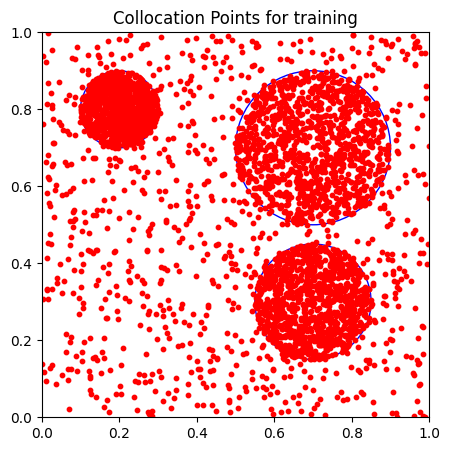

In [6]:
num_samples_pde = 1000

# Generate random points on the whole domain
x_domain = np.random.uniform(size=(num_samples_pde,2))

# Generate random points on the circles
num_points_per_circle = 1000
points = generate_random_points_in_circles(circles, num_points_per_circle)

x_domain= np.append(x_domain,points, axis=0)

# Generate random time coordinates
t_domain = np.random.uniform(size=((num_samples_pde + 3 *num_points_per_circle),1))
t_domain = t_domain.reshape(-1, 1)

# Put the coordinates together and sort from earliest to latest time
x_domain = np.hstack((x_domain, t_domain))
x_domain[:,2] *= Tf
x_domain = x_domain[x_domain[:, 2].argsort()]

# Visualize points
plt.figure(figsize=(5, 5))
for circle in circles:
    center_x, center_y, radius = circle
    circle_plot = plt.Circle((center_x, center_y), radius, color='b', fill=False)
    plt.gca().add_artist(circle_plot)
    
plt.scatter(x_domain[:, 0], x_domain[:, 1], color='r', s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Collocation Points for training')
plt.show()

In [7]:
# Old random point generation

# num_samples_pde = 125

# x_domain = np.random.uniform(size=(num_samples_pde,3))
# # print(x_domain)
# # print("\n")
# x_domain[:,2] *= Tf
# # print(x_domain)
# # print("\n")

# x_domain = x_domain[x_domain[:, 2].argsort()]

In [8]:
x_domain = torch.tensor(x_domain)

Sigma = compute_sigma(x_domain,x_domain.shape[0],0)

In [9]:
# Loss function
def eval_loss_pde(u_pred, x, f):
    return (compute_pde_residual(u_pred, x, f).pow(2)).mean()

def compute_pde_residual(u_pred, x, f):
    
    grad_u_pred = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred),
            retain_graph=True, create_graph=True, only_inputs=True)[0]

    grad2_u_pred_xx = torch.autograd.grad(grad_u_pred[:, 0].unsqueeze(1), x, grad_outputs=torch.ones_like(u_pred),
            retain_graph=True, create_graph=True, only_inputs=True)[0][:, 0]
    grad2_u_pred_yy = torch.autograd.grad(grad_u_pred[:, 1].unsqueeze(1), x, grad_outputs=torch.ones_like(u_pred),
            retain_graph=True, create_graph=True, only_inputs=True)[0][:, 1]
    grad_u_pred_t = grad_u_pred[:,2]
    f = f.flatten()
    
    Sigma = compute_sigma(x,x.shape[0],0)

    residual = Sigma*grad2_u_pred_xx + Sigma*grad2_u_pred_yy - grad_u_pred_t - f

    return residual

In [10]:
# Right-hand side function
def rhs(x):
    return a*(x-ft)*(x-fr)*(x-fd)

In [11]:
# Initial condition
def initial_condition(coord):
    if coord.dim() == 1:
        coord = coord.unsqueeze(0)
    x_coord = coord[:,0].unsqueeze(1)
    y_coord = coord[:,1].unsqueeze(1)
    return ((x_coord <= 0.1) & (y_coord >= 0.9)).to(torch.float64)

In [12]:
# PINN
class PDE_Net(nn.Module):
    def __init__(self):
        super(PDE_Net, self).__init__()
        hidden_features = 100
        in_features = 3
        out_features = 1
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, out_features)
        self.act = nn.Tanh()
        # Initialize weights and biases
        self.initialize_weights()

    def initialize_weights(self):
        # Example initialization: He initialization for weights and zeros for biases
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='tanh')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, coord):
        t_coord = coord[:,2].unsqueeze(1)
        t_coord = t_coord/Tf
        # Compute PINN output
        x_out = self.act(self.fc1(coord))
        x_out = self.act(self.fc2(x_out))
        x_out = self.fc3(x_out)
        # Apply hard constraint for initial condition
        x_out = x_out * t_coord
        x_out = x_out  + initial_condition(coord)
        return x_out


In [13]:
model = PDE_Net()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
num_epochs = 500

losses = []

In [15]:
for epoch in range(num_epochs):
    x_domain.requires_grad = True

    u_pred = model(x_domain)
    f = rhs(u_pred)
    total_loss = eval_loss_pde(u_pred, x_domain, f)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())

    if (epoch+1) % 100 == 0:
        print ('Epoch [{:5d}/{:5d}], Total Loss: {:.4e} '.format(
            epoch+1, num_epochs, total_loss.item()))

Epoch [  100/  500], Total Loss: 2.3897e+00 
Epoch [  200/  500], Total Loss: 2.0947e+00 
Epoch [  300/  500], Total Loss: 1.9145e+00 
Epoch [  400/  500], Total Loss: 1.7842e+00 
Epoch [  500/  500], Total Loss: 1.6778e+00 


In [16]:
best_model_path = '_model.pth'
torch.save(model.state_dict(), best_model_path)

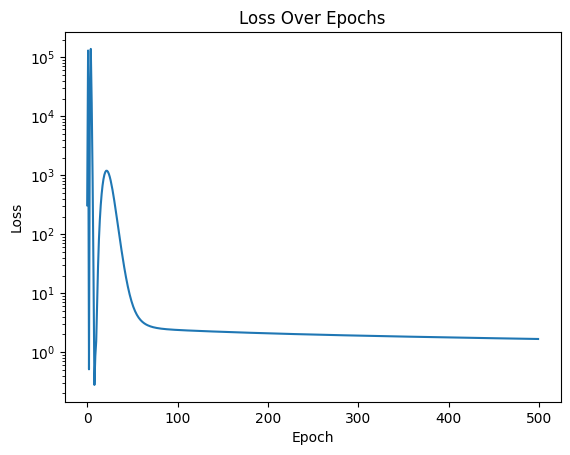

In [17]:
plt.semilogy(losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.show()

In [18]:
xmin = 0.
ymin = 0.
zmin = 0.
xmax = 1.
ymax = 1.
zmax = 1.
step = 50
stepj = step * 1j

# Generate test collocation points
Z, X, Y = np.mgrid[zmin:zmax:stepj, xmin:xmax:stepj, ymin:ymax:stepj]
test_collocation = np.vstack([X.ravel(), Y.ravel(),Z.ravel()]).T
test_collocation = torch.tensor(test_collocation)

test_collocation[:,2] *= 1

x, y = np.mgrid[xmin:xmax:stepj, ymin:ymax:stepj]

<Figure size 1000x1000 with 0 Axes>

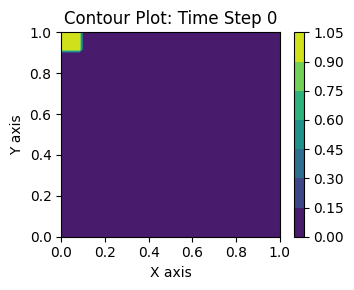

<Figure size 1000x1000 with 0 Axes>

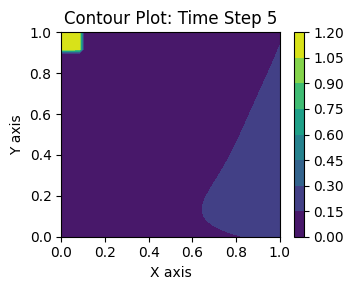

<Figure size 1000x1000 with 0 Axes>

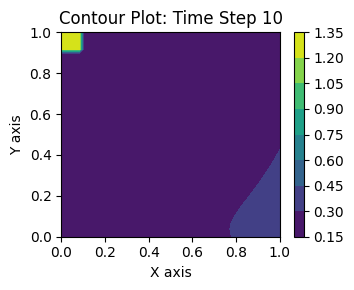

<Figure size 1000x1000 with 0 Axes>

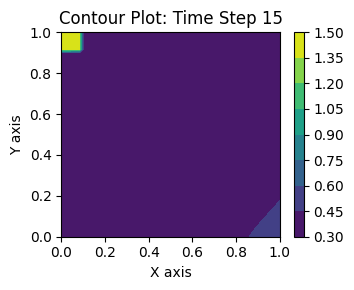

<Figure size 1000x1000 with 0 Axes>

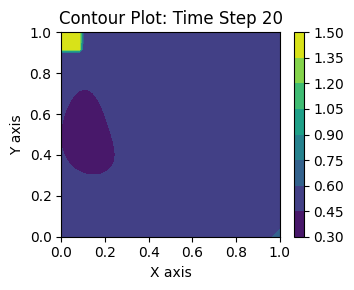

<Figure size 1000x1000 with 0 Axes>

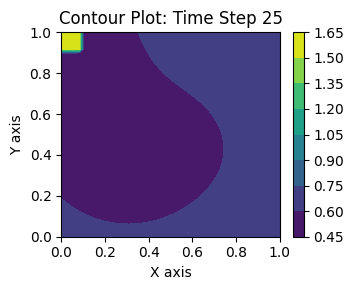

<Figure size 1000x1000 with 0 Axes>

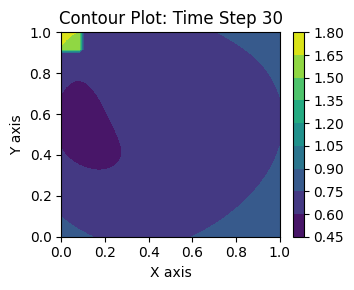

<Figure size 1000x1000 with 0 Axes>

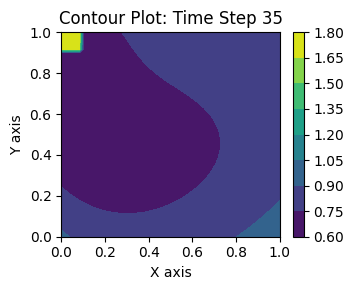

<Figure size 1000x1000 with 0 Axes>

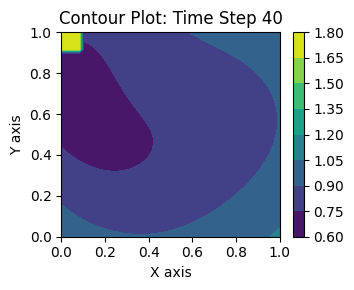

<Figure size 1000x1000 with 0 Axes>

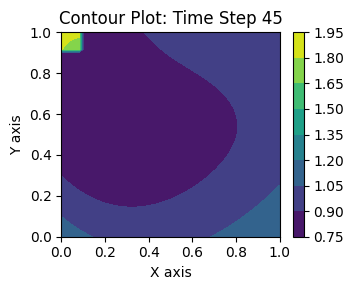

In [19]:
test_collocation.requires_grad = True

model.load_state_dict(torch.load(best_model_path))

u_nn_domain = model(test_collocation)

#print(u_nn_domain)

u_nn_domain = u_nn_domain.data.numpy()
u_nn_domain = u_nn_domain.reshape(X.shape)

# print(u_nn_domain)

# Print contour plot of the solution at different time steps
for i in range(step):
    if i % int(step//10) == 0:
        fig = plt.figure(figsize=(10, 10))

        # # 3D plot with surface plot
        # ax1 = fig.add_subplot(131, projection='3d')
        # ax1.plot_surface(x, y, u_nn_domain[i, :, :], cmap='viridis')
        # ax1.set_title(f'Time Step: {i}')
        # ax1.set_xlabel('X axis')
        # ax1.set_ylabel('Y axis')
        # ax1.set_zlabel('Solution')
        # ax1.set_zlim(0, 1)
        # ax1.view_init(elev=20, azim=30)

        # # 2D plot (top view)
        # ax2 = fig.add_subplot(132, projection='3d')
        # ax2.plot_surface(x, y, u_nn_domain[i, :, :], cmap='viridis')
        # ax2.set_title(f'Time Step: {i}')
        # ax2.set_xlabel('X axis')
        # ax2.set_ylabel('Y axis')
        # ax2.set_zlabel('Solution')
        # ax2.set_zlim(0, 1)
        # ax2.view_init(elev=90, azim=-90)

        fig2 = plt.figure(figsize=(10, 3))
        # Contour plot (top view)
        ax3 = fig2.add_subplot(133)
        contour = ax3.contourf(x, y, u_nn_domain[i, :, :], cmap='viridis')
        fig2.colorbar(contour, ax=ax3)
        ax3.set_title(f'Contour Plot: Time Step {i}')
        ax3.set_xlabel('X axis')
        ax3.set_ylabel('Y axis')

        plt.tight_layout()

        plt.pause(0.1)
        plt.show()


In [142]:
# Generate video animation

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

def update_plot(i):
    ax1.cla()
    ax2.cla()

    # 3D plot with surface plot
    ax1.plot_surface(x, y, u_nn_domain[i, :, :], cmap='viridis')
    ax1.set_title(f'Time Step: {i}')
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Solution')
    ax1.set_zlim(0, 1)
    ax1.view_init(elev=20, azim=30)

    # 2D plot (top view)
    ax2.plot_surface(x, y, u_nn_domain[i, :, :], cmap='viridis')
    # fig.colorbar(c, ax=axs[3], label='Value')
    ax2.set_title(f'Time Step: {i}')
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.set_zlabel('Solution')
    ax2.set_zlim(0, 1)
    ax2.view_init(elev=90, azim=-90)

ani = animation.FuncAnimation(fig, update_plot, frames=step, repeat=False)

# Save the animation
ani.save('solution_PINNs.mp4', writer='ffmpeg', fps=10)

plt.show()